In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
from DTW import _traceback, dtwPlotTwoWay
from tqdm import tqdm
from tslearn.barycenters import softdtw_barycenter

In [3]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [6]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    # plt.figure()
    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
        # plt.plot(signal[begin: end])
    # plt.show()
    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    # pieces_padded = np.array(pieces_padded)
    return pieces_padded

In [7]:
from numpy import zeros, inf

def scaled_dtw(x, y, dist, lambda_x=1, lambda_y=1):
    assert len(x)
    assert len(y)
    assert lambda_x > 0
    assert lambda_y > 0

    r, c = len(x), len(y)

    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf

    D1 = D0[1:, 1:]  # view

    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()

    jrange = range(c)
    for i in range(r):
        for j in jrange:
            min_list = [D0[i, j]]
            i_1 = min(i + 1, r)
            j_1 = min(j + 1, c)
            min_list += [D0[i_1, j], D0[i, j_1]]
            # print(np.argmin(min_list))
            min_pos = np.argmin(min_list)

            coff = 1
            if min_pos == 0:
                coff = 0.5 * (lambda_x + lambda_y)
            elif min_pos == 1:
                coff = lambda_x
            elif min_pos == 2:
                coff = lambda_y
            D1[i, j] += min(min_list) * coff

    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

In [8]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()


    return [dis12/dis21, A0/A1]

In [9]:
def make_template(piece1, piece2,  path, lambda_x, lambda_y):
    path1 = path[0]
    path2 = path[1]
    y = []

    for x_1, x_2 in zip(path1, path2):
        y_new = (piece1[x_1] * lambda_x + piece2[x_2] * lambda_y) / (lambda_x + lambda_y)
        y.append(y_new)

    return np.array(y)

In [18]:
from math import floor
def uniform_scaling(template, n_target):
    # n_template -> n_target
    n_template = len(template)
    uniformed_template = [template[floor(i * n_template / n_target)] for i in range(n_target)]
    return uniformed_template

from sklearn.cluster import AgglomerativeClustering
def performpsa(pieces):
    dist = lambda x, y: np.abs(x - y)
    weights = [1] * len(pieces)

    while len(pieces) > 1:
        clustering = AgglomerativeClustering(n_clusters=len(pieces)-1).fit(pieces)

        idx_1, idx_2 = np.where(clustering.labels_ == 0)[0]
        A, B = pieces[idx_1], pieces[idx_2]
        w_A, w_B = weights[idx_1], weights[idx_2]
        _, _, _, path = scaled_dtw(A, B, dist, w_A, w_B)
        template = make_template(A, B, path, w_A, w_B)
        w_template = w_A + w_B
        uniformed_template = uniform_scaling(template, min(len(A), len(B)))
        pieces.append(uniformed_template)
        weights.append(w_template)
        pieces = pieces[2:]
        weights = weights[2:]

    return np.array(pieces[0])


def extract_dtw(signals, labels, alpha,  h, d, echo):
    psa_features = []
    idxs = []

    for cnt, signal in tqdm(enumerate(signals)):
        hr = labels[cnt, 2]
        large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
        pieces = segmentation(signal, large_peaks)

        template = softdtw_barycenter(pieces)
        template = template.reshape((-1,))
        plt.figure(figsize=(12, 3))
        plt.plot(template)
        plt.show()
        features = get_features(template, h, d)

        if features is not None:
            idxs.append(cnt)
            psa_features.append(features)

        if cnt > echo:
            break
    return np.array(psa_features), np.array(idxs)


(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


0it [00:00, ?it/s]

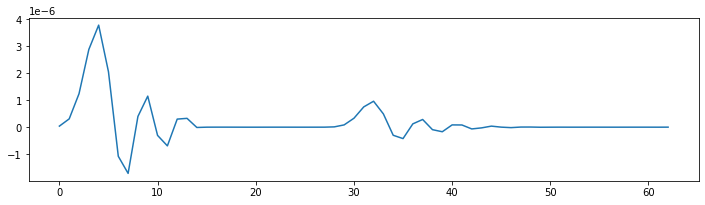

1it [00:00,  4.99it/s]

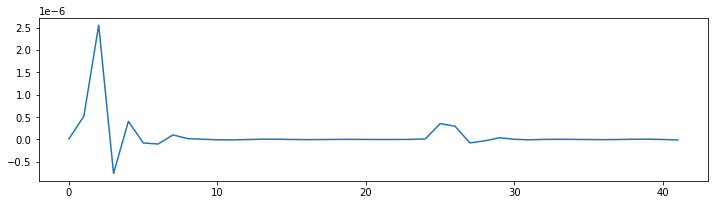

2it [00:00,  4.58it/s]

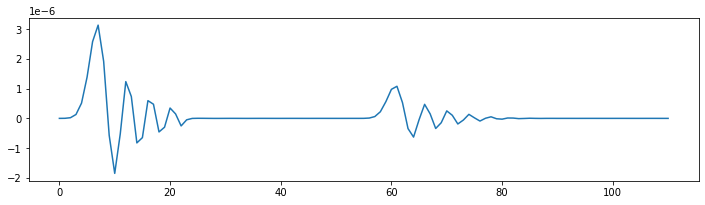

3it [00:00,  4.46it/s]

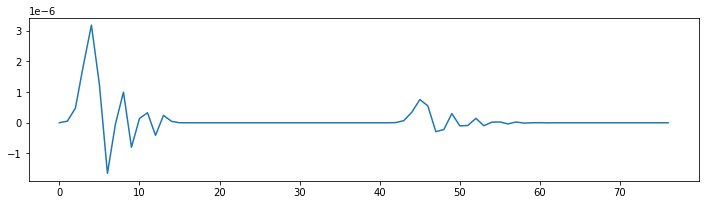

3it [00:00,  3.15it/s]
0it [00:00, ?it/s]

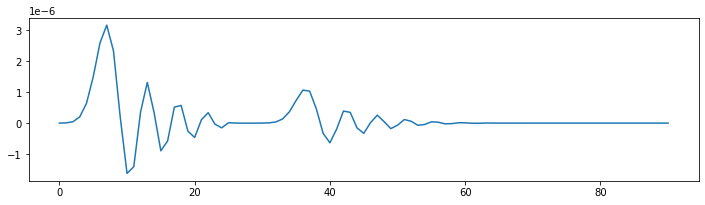

1it [00:00,  3.63it/s]

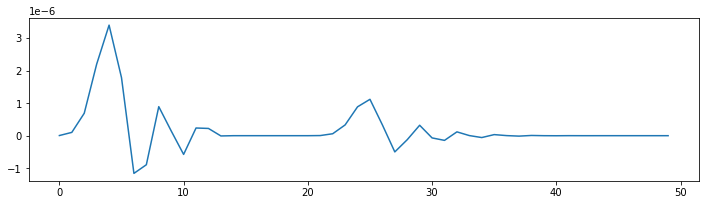

2it [00:00,  3.63it/s]

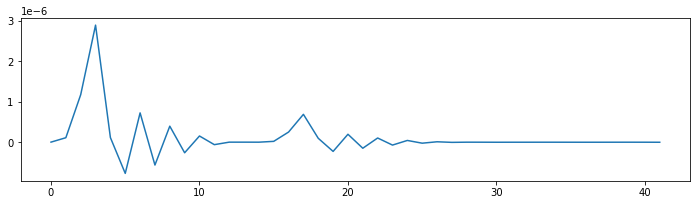

3it [00:00,  3.76it/s]

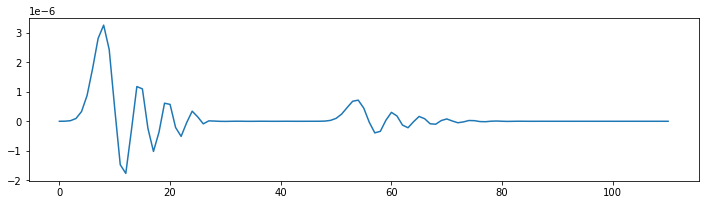

3it [00:01,  2.81it/s]


In [19]:
if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    echo1, echo2 = 2, 2
    psa_features_train, idxs_train = extract_dtw(signals_0_train,labels_0_train,1,0.1,0.15,echo1)
    psa_features_test, idxs_test = extract_dtw(signals_0_test, labels_0_test,1,0.12,0.12,echo2)

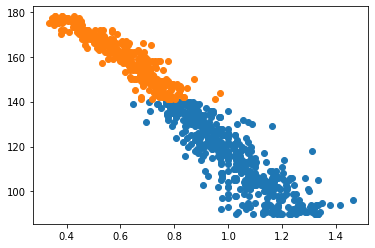

8.432531551281402


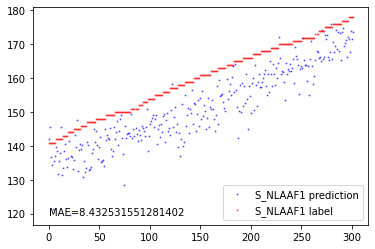

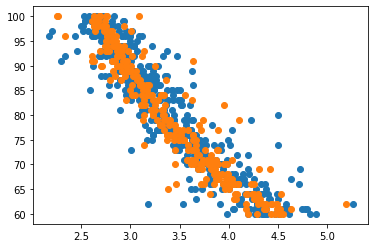

3.147702986037632


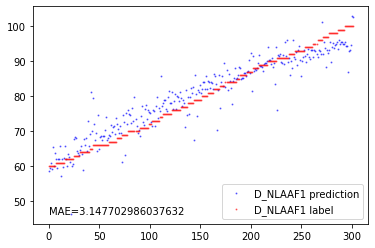

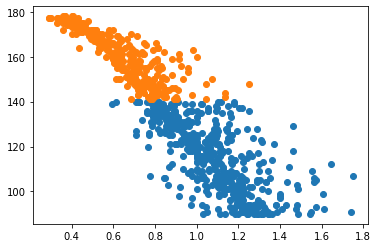

20.674646230657064


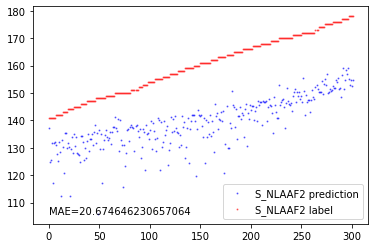

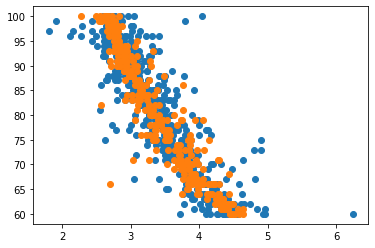

3.6412564029127292


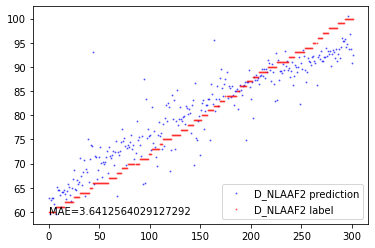

In [99]:
from sklearn.linear_model import LinearRegression as LR

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(NLAAF1_features_train[:, 0],NLAAF1_features_test[:, 0],labels_0_train[idxs_1_train, 4],labels_0_test[idxs_1_test, 4],'S_PSA')
plot_plot(NLAAF1_features_train[:, 1],NLAAF1_features_test[:, 1],labels_0_train[idxs_1_train, 5],labels_0_test[idxs_1_test, 5],'D_PSA')


In [93]:
def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()